<a href="https://colab.research.google.com/github/bmil-ssu/advanced_ann/blob/main/1_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-3

H_NODE_1 = 512
H_NODE_2 = 512

# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 학습 데이터를 학습/검증 데이터로 분리합니다.
training_data, validation_data = train_test_split(training_data, test_size=1000)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=len(test_data))

# 데이터의 형태를 확인합니다.
for X, y in test_dataloader:
    input_shape = X.shape[2] * X.shape[3]
    print(f"Shape of input: {input_shape}")
    num_class = len(y.unique())
    print(f"num of class: {num_class}")
    break

Shape of input: 784
num of class: 10


In [5]:
# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_shape, H_NODE_1),
            nn.ReLU(),
            nn.Linear(H_NODE_1, H_NODE_2),
            nn.ReLU(),
            nn.Linear(H_NODE_2, num_class)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
# 손실함수와 optimizer를 설정합니다.
LOSS_FN = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [7]:
# train 함수를 정의합니다.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # 데이터를 모델에 입력합니다.
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X, y = X.to(device), y.to(device)

        # 예측 손실값을 계산합니다.
        pred = model(X)
        loss = loss_fn(pred, y)

        # 손실값을 역전파하여 모델을 갱신합니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [8]:
# test 함수를 정의합니다.
def test(dataloader, model, loss_fn, confusion):
    # 필요한 변수를 설정합니다.
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    # 데이터를 모델에 입력합니다.
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # 모델의 예측값과 실제 정답값 사이의 손실값을 계산하여 누적합니다.
            test_loss += loss_fn(pred, y).item()
            # 모델의 예측값과 실제 정답값이 일치하는 경우의 수를 셉니다.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # confusion matrix를 통해 다양한 성능 평가 지표를 확인합니다.
            ## test 데이터에 대해서만 확인을 진행합니다. (입력 변수 confusion=True 일 때만 진행합니다.)
            if confusion:
                predicted = pred.argmax(1)
                conf_matrix = confusion_matrix(y, predicted)

                recall = 0
                precision = 0
                f1_score = 0
                for n in range(num_class):
                    TP = (conf_matrix[n][n])
                    FP = (conf_matrix[n].sum()-TP)
                    FN = (conf_matrix.T[n].sum()-TP)
                    TN = (len(test_data)-TP-FP-FN)

                    # recall(재현도)를 계산하여 누적합니다.
                    ## 실제 n번째 클래스인 데이터 중, 예측을 n번째 클래스로 한 비율을 의미합니다. (분모: 실제 n번째 클래스(tp+fn))
                    ## 전체 데이터를 n번째 클래스로 하면 1이 나온다는 맹점이 존재합니다. (이 경우 precision이 낮아집니다.)
                    recall += TP/(TP+FN)

                    # precision(정밀도)를 계산하여 누적합니다.
                    ## 예측을 n번째 클래스로 한 데이터 중, 실제 n번째 클래스인 데이터의 비율을 의미합니다. (분모: 예측 n번째 클래스(tp+fp))
                    ## 예측을 극단적으로 자명한 것들에 대해서만 하여 fp를 줄이면 1에 가까운 값을 유도할 수 있다는 맹점이 존재합니다. (이 경우 recall이 낮아집니다.)
                    precision += TP/(TP+FP)

                    # recall과 precision의 조화평균인 f1 score를 계산하여 누적합니다.
                    ## recall과 precision의 조화평균으로, 둘 모두를 고려한 평가 지표입니다.
                    ## multiclass classification에서, f1 score를 통해 모델이 여러 클래스에 대한 올바른 예측을 하였는지 종합적으로 판단할 수 있습니다.
                    f1_score += (2*recall*precision)/(precision+recall)

                print("Recall".ljust(10),":", str(recall/num_class).ljust(10))
                print("Precision".ljust(10),":", str(precision/num_class).ljust(10))
                print("F1-score".ljust(10),":", str(f1_score/num_class).ljust(10))


    # 누적된 손실값의 평균을 내어 데이터 전체에 대한 손실값을 확인합니다.
    test_loss /= num_batches
    # 예측값과 정답값이 일치하는 경우의 수를 전체 데이터 개수로 나누어 정확도를 확인합니다.
    correct /= size

    return 100*correct, test_loss

In [22]:
# 데이터 샘플 하나에 대한 모델의 결과를 확인하는 sample test 함수를 정의합니다.
def sample_test(data, model, index):
    print("Sample image")
    plt.imshow(test_data[index][0][0])
    plt.show()

    print("True label".ljust(15),":", str(test_data[index][1]).ljust(10))

    pred = model(test_data[index][0])
    print("Predicted label".ljust(15),":", str(pred.argmax(1).item()).ljust(10))
    print()

Epoch 1
-------------------------------


922it [00:11, 81.04it/s]


Train Error: 
 Accuracy: 34.0%, Avg loss: 2.255695 

Train Error: 
 Accuracy: 33.3%, Avg loss: 2.256802 

Epoch 2
-------------------------------


922it [00:06, 148.33it/s]


Train Error: 
 Accuracy: 50.6%, Avg loss: 2.188716 

Train Error: 
 Accuracy: 49.3%, Avg loss: 2.191251 

Epoch 3
-------------------------------


922it [00:07, 127.75it/s]


Train Error: 
 Accuracy: 58.6%, Avg loss: 2.075289 

Train Error: 
 Accuracy: 58.4%, Avg loss: 2.079524 

Epoch 4
-------------------------------


922it [00:06, 132.04it/s]


Train Error: 
 Accuracy: 64.8%, Avg loss: 1.880137 

Train Error: 
 Accuracy: 64.6%, Avg loss: 1.885550 

Epoch 5
-------------------------------


922it [00:05, 155.55it/s]


Train Error: 
 Accuracy: 69.9%, Avg loss: 1.591585 

Train Error: 
 Accuracy: 70.0%, Avg loss: 1.596707 

Epoch 6
-------------------------------


922it [00:06, 138.25it/s]


Train Error: 
 Accuracy: 75.2%, Avg loss: 1.280495 

Train Error: 
 Accuracy: 74.2%, Avg loss: 1.284334 

Epoch 7
-------------------------------


922it [00:07, 123.92it/s]


Train Error: 
 Accuracy: 79.0%, Avg loss: 1.034989 

Train Error: 
 Accuracy: 79.1%, Avg loss: 1.038360 

Epoch 8
-------------------------------


922it [00:06, 137.33it/s]


Train Error: 
 Accuracy: 81.2%, Avg loss: 0.866124 

Train Error: 
 Accuracy: 80.9%, Avg loss: 0.869629 

Epoch 9
-------------------------------


922it [00:06, 147.72it/s]


Train Error: 
 Accuracy: 82.8%, Avg loss: 0.750721 

Train Error: 
 Accuracy: 81.9%, Avg loss: 0.754699 

Epoch 10
-------------------------------


922it [00:07, 126.41it/s]


Train Error: 
 Accuracy: 83.9%, Avg loss: 0.669108 

Train Error: 
 Accuracy: 83.3%, Avg loss: 0.673783 

Done!


Text(0.5, 1.0, 'Epoch-Loss Curve')

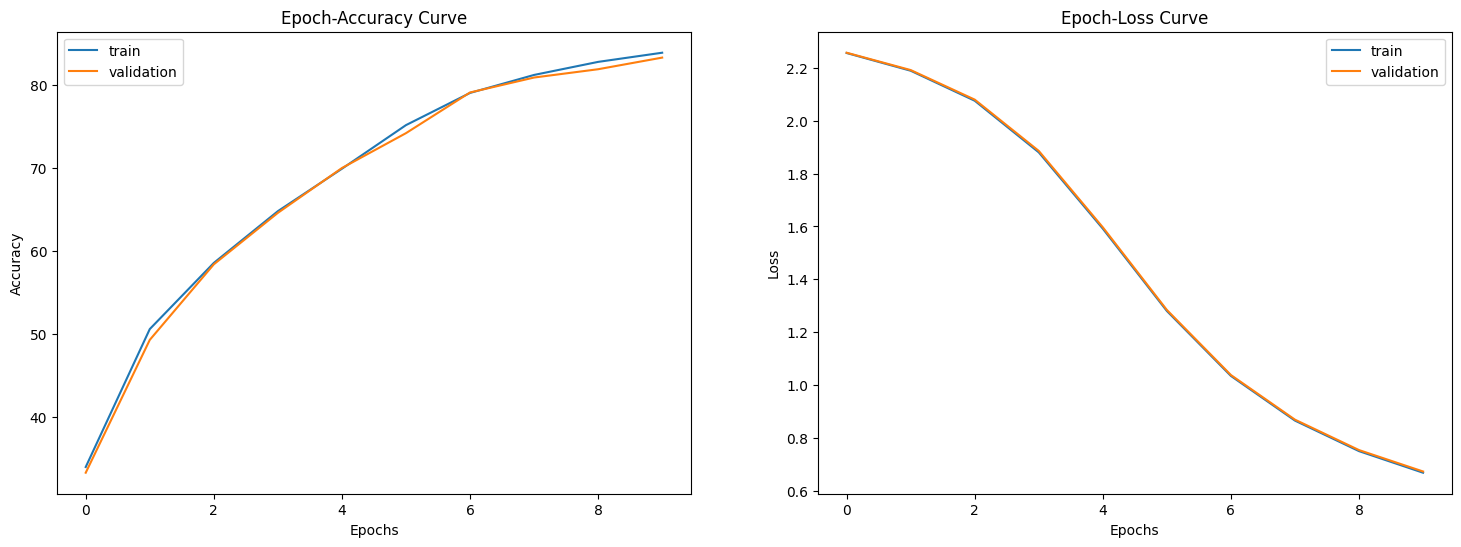

In [10]:
# 학습을 진행합니다.

# 학습의 경향성을 확인하기 위해 train과 validation 데이터에 대한 정확도와 손실값의 리스트를 생성합니다.
train_acc_list = []
train_loss_list = []

val_acc_list = []
val_loss_list = []

# 사전에 정의해둔 epochs 만큼 반복 학습을 진행합니다.
for t in range(EPOCHS):
    # t 번째 학습을 진행합니다.
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, LOSS_FN, OPTIMIZER)

    # t 번째 학습을 진행한 후, train 데이터에 대한 정확도와 손실값을 확인합니다.
    train_acc, train_loss = test(train_dataloader, model, LOSS_FN, False)
    print(f"Train Error: \n Accuracy: {train_acc:>0.1f}%, Avg loss: {train_loss:>8f} \n")
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # t 번째 학습을 진행한 후, validation 데이터에 대한 정확도와 손실값을 확인합니다.
    val_acc, val_loss = test(validation_dataloader, model, LOSS_FN, False)
    print(f"Train Error: \n Accuracy: {val_acc:>0.1f}%, Avg loss: {val_loss:>8f} \n")
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

print("Done!")

# 모든 epochs에 대하여, 정확도와 손실값의 경향성을 시각적으로 확인합니다.
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(train_acc_list,label="train")
plt.plot(val_acc_list,label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Epoch-Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(train_loss_list,label="train")
plt.plot(val_loss_list,label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Epoch-Loss Curve")

In [11]:
# test 데이터에 대한 정확도를 확인합니다.
test_acc, test_loss = test(test_dataloader, model, LOSS_FN, False)
print(f"Train Error: \n Accuracy: {test_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")

Train Error: 
 Accuracy: 84.3%, Avg loss: 0.650968 



In [12]:
# test 데이터를 활용하여, 모델의 다양한 성능 지표를 확인합니다.
test_acc, test_loss = test(test_dataloader, model, LOSS_FN, True)


Recall     : 0.8416510708813216
Precision  : 0.8396329946549035
F1-score   : 4.727411237560451


Sample image


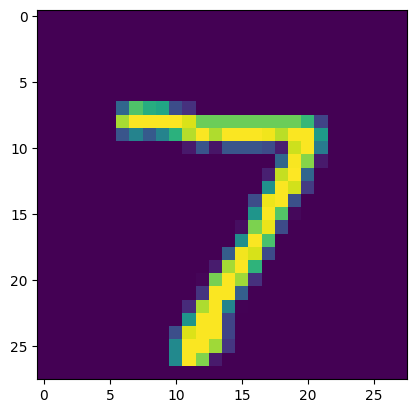

True label      : 7         
Predicted label : 7         

Sample image


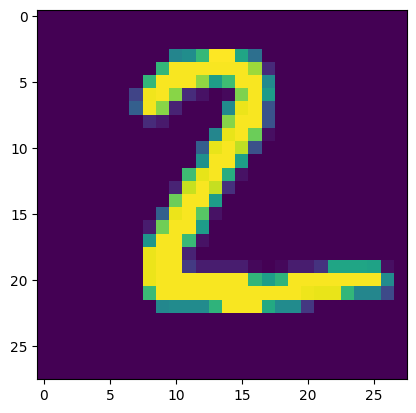

True label      : 2         
Predicted label : 2         

Sample image


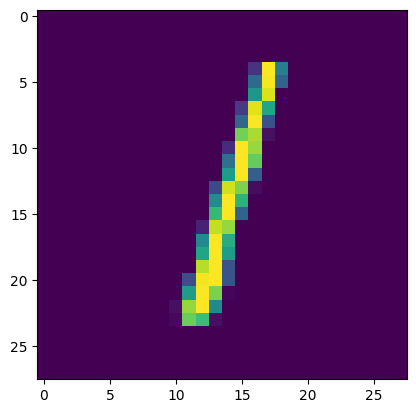

True label      : 1         
Predicted label : 1         

Sample image


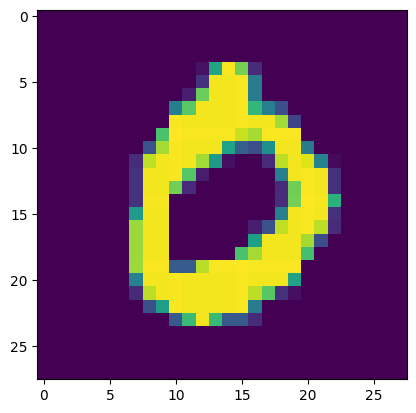

True label      : 0         
Predicted label : 0         

Sample image


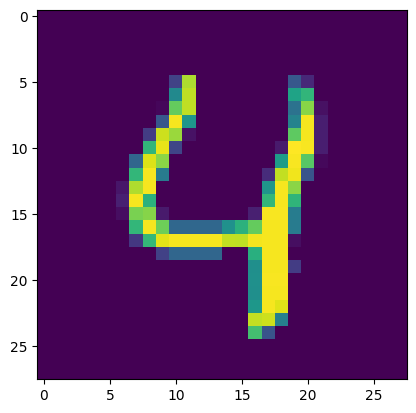

True label      : 4         
Predicted label : 4         

Sample image


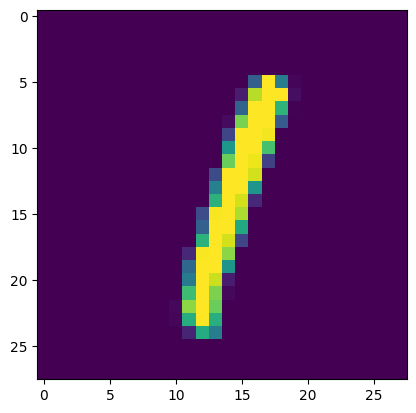

True label      : 1         
Predicted label : 1         

Sample image


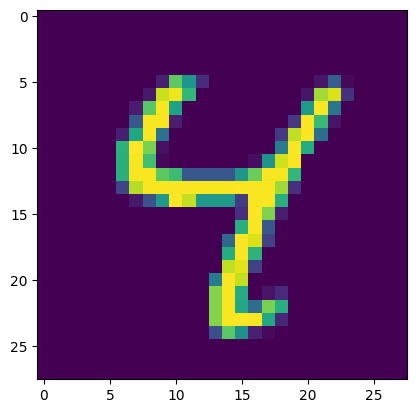

True label      : 4         
Predicted label : 9         

Sample image


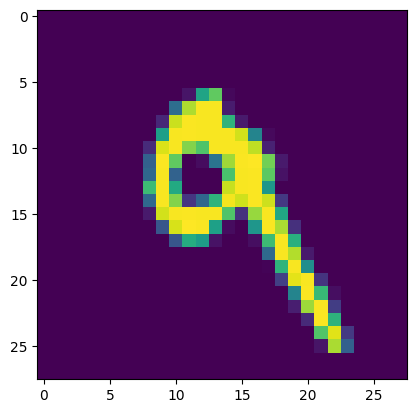

True label      : 9         
Predicted label : 4         

Sample image


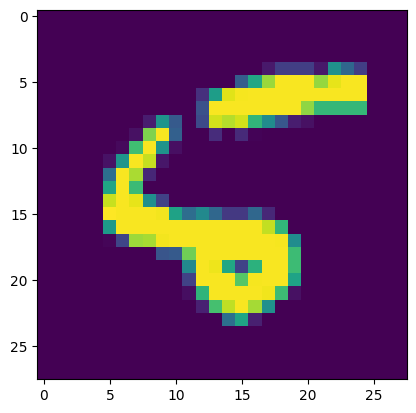

True label      : 5         
Predicted label : 6         

Sample image


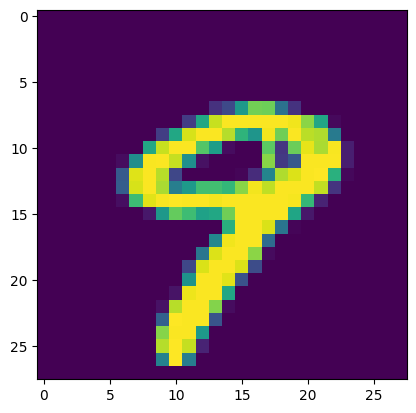

True label      : 9         
Predicted label : 9         



In [23]:
# 모델의 실제 동작을 확인합니다.
for i in range(10):
    sample_test(test_data, model, i)